# HW5 — LLM 微調：情緒分類與憂鬱症風險監測
## LoRA / Zero-shot / Few-shot

**作業目標：**
- 使用 HuggingFace Datasets 載入情緒資料集
- 建立 Emotion → Depression-risk 的轉換規則
- 比較 Zero-shot、Few-shot、LoRA 微調三種方法
- 完成情緒分類與風險分類（低／中／高）
- 訓練並評估模型效能（F1、AUROC、PR-AUC、Confusion Matrix）
- 完成憂鬱症風險監測視覺化

**資料集：** Emotion Dataset (Saravia et al., 2018)  
**標籤：** joy, love, surprise, anger, fear, sadness  
**風險映射：**
- joy/love/surprise → low_risk (0)
- anger/fear → mid_risk (1)
- sadness → high_risk (2)

## 1. 環境設置與套件安裝

In [1]:
# Install required packages
!pip install -q transformers datasets accelerate peft bitsandbytes sentencepiece
!pip install -q scikit-learn matplotlib seaborn pandas numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.2 MB/s eta 0:00:00


In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


## 2. 資料載入與探索

In [3]:
# Load Emotion dataset from HuggingFace
print("Loading Emotion dataset...")
dataset = load_dataset("dair-ai/emotion")

print("\nDataset structure:")
print(dataset)

print("\nSample from training set:")
print(dataset['train'][0])

# Emotion labels mapping
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
print("\nEmotion labels:")
for i, emotion in enumerate(emotion_names):
    print(f"{i}: {emotion}")

Loading Emotion dataset...


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Sample from training set:
{'text': 'i didnt feel humiliated', 'label': 0}

Emotion labels:
0: sadness
1: joy
2: love
3: anger
4: fear
5: surprise


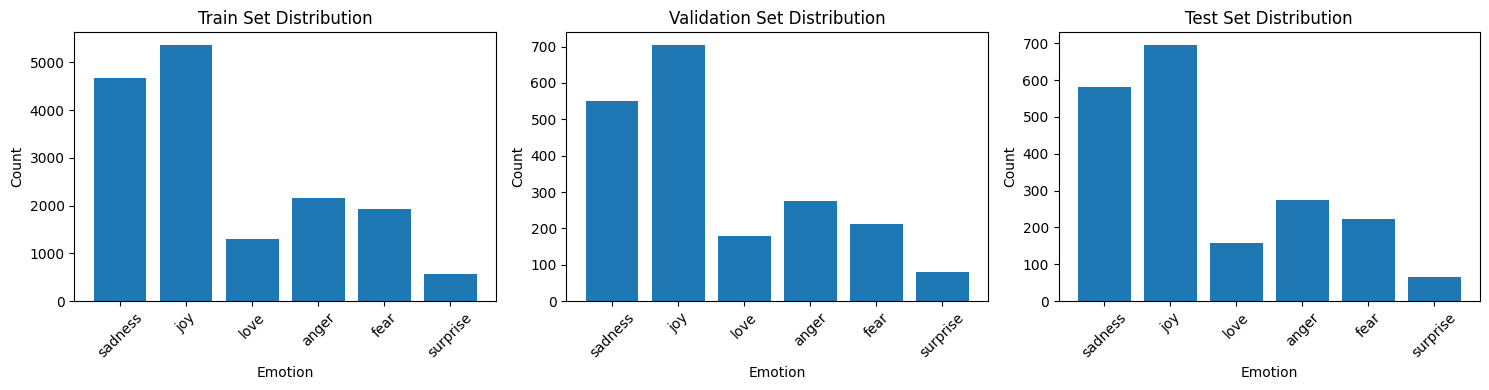


Dataset sizes:
Train: 16000
Validation: 2000
Test: 2000


In [4]:
# Analyze dataset distribution
train_labels = [dataset['train'][i]['label'] for i in range(len(dataset['train']))]
val_labels = [dataset['validation'][i]['label'] for i in range(len(dataset['validation']))]
test_labels = [dataset['test'][i]['label'] for i in range(len(dataset['test']))]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (labels, split_name) in enumerate([(train_labels, 'Train'),
                                              (val_labels, 'Validation'),
                                              (test_labels, 'Test')]):
    label_counts = pd.Series(labels).value_counts().sort_index()
    axes[idx].bar([emotion_names[i] for i in label_counts.index], label_counts.values)
    axes[idx].set_title(f'{split_name} Set Distribution')
    axes[idx].set_xlabel('Emotion')
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nDataset sizes:")
print(f"Train: {len(dataset['train'])}")
print(f"Validation: {len(dataset['validation'])}")
print(f"Test: {len(dataset['test'])}")

## 3. 情緒到風險的映射規則

In [5]:
# Emotion to Depression Risk Mapping
# joy(1), love(2), surprise(5) -> low_risk (0)
# anger(3), fear(4) -> mid_risk (1)
# sadness(0) -> high_risk (2)

emotion_to_risk = {
    0: 2,  # sadness -> high_risk
    1: 0,  # joy -> low_risk
    2: 0,  # love -> low_risk
    3: 1,  # anger -> mid_risk
    4: 1,  # fear -> mid_risk
    5: 0   # surprise -> low_risk
}

risk_names = ['low_risk', 'mid_risk', 'high_risk']

print("Emotion to Risk Mapping:")
for emotion_id, risk_id in emotion_to_risk.items():
    print(f"{emotion_names[emotion_id]:10s} -> {risk_names[risk_id]}")

# Add risk labels to dataset
def add_risk_label(example):
    example['risk'] = emotion_to_risk[example['label']]
    example['emotion_name'] = emotion_names[example['label']]
    example['risk_name'] = risk_names[emotion_to_risk[example['label']]]
    return example

dataset = dataset.map(add_risk_label)

print("\nSample with risk labels:")
print(dataset['train'][0])

Emotion to Risk Mapping:
sadness    -> high_risk
joy        -> low_risk
love       -> low_risk
anger      -> mid_risk
fear       -> mid_risk
surprise   -> low_risk


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]


Sample with risk labels:
{'text': 'i didnt feel humiliated', 'label': 0, 'risk': 2, 'emotion_name': 'sadness', 'risk_name': 'high_risk'}


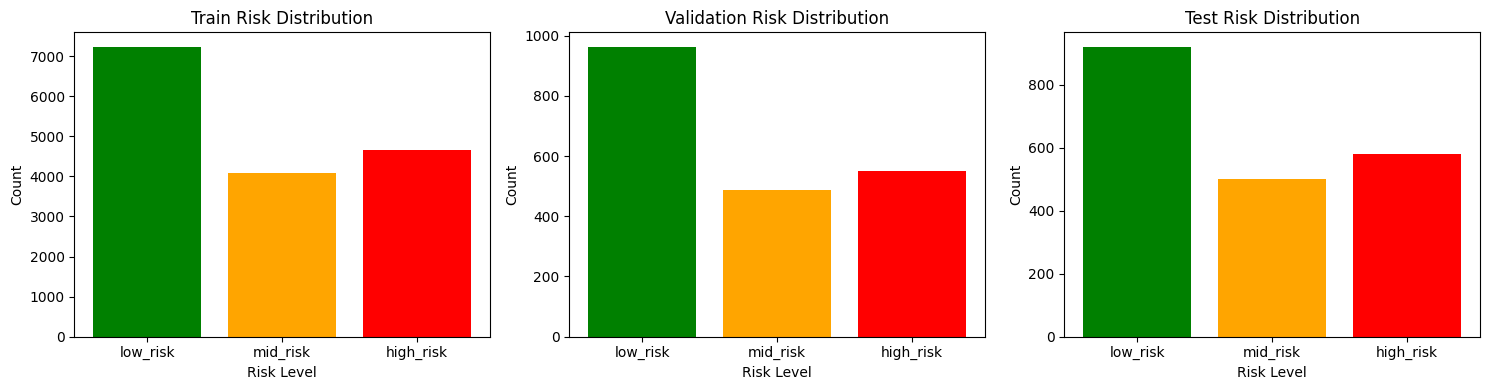

In [6]:
# Analyze risk distribution
train_risks = [dataset['train'][i]['risk'] for i in range(len(dataset['train']))]
val_risks = [dataset['validation'][i]['risk'] for i in range(len(dataset['validation']))]
test_risks = [dataset['test'][i]['risk'] for i in range(len(dataset['test']))]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (risks, split_name) in enumerate([(train_risks, 'Train'),
                                             (val_risks, 'Validation'),
                                             (test_risks, 'Test')]):
    risk_counts = pd.Series(risks).value_counts().sort_index()
    colors = ['green', 'orange', 'red']
    axes[idx].bar([risk_names[i] for i in risk_counts.index],
                  risk_counts.values,
                  color=[colors[i] for i in risk_counts.index])
    axes[idx].set_title(f'{split_name} Risk Distribution')
    axes[idx].set_xlabel('Risk Level')
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 4. 模型選擇與設定

In [7]:
# Model configuration
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # Using TinyLlama for efficiency
MAX_LENGTH = 128

print(f"Loading model: {MODEL_NAME}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Tokenizer loaded. Vocab size: {len(tokenizer)}")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Tokenizer loaded. Vocab size: 32000


## 5. Zero-shot 推論

In [8]:
# Load base model for zero-shot
print("Loading model for zero-shot inference...")

# Use 4-bit quantization for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

print("Model loaded successfully!")

Loading model for zero-shot inference...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded successfully!


In [9]:
# Zero-shot prompt template
def create_zero_shot_prompt(text):
    prompt = f"""<|system|>
You are an emotion classifier. Classify the following text into one of these emotions: sadness, joy, love, anger, fear, surprise.
Respond with only the emotion label, nothing else.</s>
<|user|>
Text: {text}
Emotion:</s>
<|assistant|>
"""
    return prompt

# Test zero-shot on a few examples
print("Testing zero-shot classification:")
test_samples = [
    dataset['test'][0],
    dataset['test'][100],
    dataset['test'][200]
]

for sample in test_samples:
    prompt = create_zero_shot_prompt(sample['text'])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    outputs = base_model.generate(
        **inputs,
        max_new_tokens=10,
        temperature=0.1,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predicted = response.split("<|assistant|>")[-1].strip().lower()

    print(f"\nText: {sample['text'][:60]}...")
    print(f"True emotion: {sample['emotion_name']}")
    print(f"Predicted: {predicted}")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Testing zero-shot classification:

Text: im feeling rather rotten so im not very ambitious right now...
True emotion: sadness
Predicted: emotion: sadness

response: sad

Text: i feel needy but comfortable with it i feel vulnerable but s...
True emotion: sadness
Predicted: emotion: needy, comfortable, vulnerable

Text: i wanted to feel him in my hands and reached out to take him...
True emotion: joy
Predicted: emotion: sadness

response: sad


In [10]:
# Zero-shot evaluation on test set (using a subset for speed)
def evaluate_zero_shot(model, dataset_split, num_samples=500):
    predictions = []
    true_labels = []

    # Use subset for efficiency
    indices = np.random.choice(len(dataset_split), min(num_samples, len(dataset_split)), replace=False)

    for idx in tqdm(indices, desc="Zero-shot evaluation"):
        sample = dataset_split[int(idx)]
        prompt = create_zero_shot_prompt(sample['text'])
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                temperature=0.1,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predicted = response.split("<|assistant|>")[-1].strip().lower()

        # Map prediction to label
        pred_label = -1
        for i, emotion in enumerate(emotion_names):
            if emotion in predicted:
                pred_label = i
                break

        if pred_label == -1:  # If no match, random guess
            pred_label = np.random.randint(0, 6)

        predictions.append(pred_label)
        true_labels.append(sample['label'])

    return np.array(predictions), np.array(true_labels)

print("Running zero-shot evaluation...")
zero_shot_preds, zero_shot_true = evaluate_zero_shot(base_model, dataset['test'], num_samples=200)

# Calculate metrics
zero_shot_f1 = f1_score(zero_shot_true, zero_shot_preds, average='weighted')
print(f"\nZero-shot Weighted F1 Score: {zero_shot_f1:.4f}")
print("\nClassification Report:")
print(classification_report(zero_shot_true, zero_shot_preds, target_names=emotion_names))

Running zero-shot evaluation...


Zero-shot evaluation:   0%|          | 0/200 [00:00<?, ?it/s]


Zero-shot Weighted F1 Score: 0.2757

Classification Report:
              precision    recall  f1-score   support

     sadness       0.43      0.64      0.52        70
         joy       0.26      0.09      0.13        69
        love       0.18      0.11      0.13        19
       anger       0.23      0.27      0.25        22
        fear       0.05      0.07      0.06        14
    surprise       0.12      0.33      0.17         6

    accuracy                           0.31       200
   macro avg       0.21      0.25      0.21       200
weighted avg       0.29      0.31      0.28       200



## 6. Few-shot 推論

In [11]:
# Few-shot prompt template with examples
def create_few_shot_prompt(text, num_examples=3):
    # Select examples (one per emotion, balanced)
    examples = []
    for emotion_id in range(6):
        # Find an example for this emotion
        for sample in dataset['train']:
            if sample['label'] == emotion_id:
                examples.append((sample['text'], emotion_names[emotion_id]))
                break

    # Select random subset
    np.random.shuffle(examples)
    examples = examples[:num_examples]

    prompt = """<|system|>
You are an emotion classifier. Classify text into one of these emotions: sadness, joy, love, anger, fear, surprise.
Here are some examples:</s>
"""

    for ex_text, ex_emotion in examples:
        prompt += f"""<|user|>
Text: {ex_text}
Emotion:</s>
<|assistant|>
{ex_emotion}</s>
"""

    prompt += f"""<|user|>
Text: {text}
Emotion:</s>
<|assistant|>
"""

    return prompt

# Test few-shot
print("Testing few-shot classification:")
sample = dataset['test'][0]
prompt = create_few_shot_prompt(sample['text'], num_examples=5)
print("Few-shot prompt:")
print(prompt[:500] + "...\n")

inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
outputs = base_model.generate(
    **inputs,
    max_new_tokens=10,
    temperature=0.1,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)

response = tokenizer.decode(outputs[0], skip_special_tokens=True)
predicted = response.split("<|assistant|>")[-1].strip().lower()
print(f"True emotion: {sample['emotion_name']}")
print(f"Predicted: {predicted}")

Testing few-shot classification:
Few-shot prompt:
<|system|>
You are an emotion classifier. Classify text into one of these emotions: sadness, joy, love, anger, fear, surprise.
Here are some examples:</s>
<|user|>
Text: im grabbing a minute to post i feel greedy wrong
Emotion:</s>
<|assistant|>
anger</s>
<|user|>
Text: i have been with petronas for years i feel that petronas has performed well and made a huge profit
Emotion:</s>
<|assistant|>
joy</s>
<|user|>
Text: ive been taking or milligrams or times recommended amount and ive fallen asleep ...

True emotion: sadness
Predicted: anger


In [12]:
# Few-shot evaluation
def evaluate_few_shot(model, dataset_split, num_samples=500, num_examples=5):
    predictions = []
    true_labels = []

    indices = np.random.choice(len(dataset_split), min(num_samples, len(dataset_split)), replace=False)

    for idx in tqdm(indices, desc="Few-shot evaluation"):
        sample = dataset_split[int(idx)]
        prompt = create_few_shot_prompt(sample['text'], num_examples=num_examples)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                temperature=0.1,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predicted = response.split("<|assistant|>")[-1].strip().lower()

        pred_label = -1
        for i, emotion in enumerate(emotion_names):
            if emotion in predicted:
                pred_label = i
                break

        if pred_label == -1:
            pred_label = np.random.randint(0, 6)

        predictions.append(pred_label)
        true_labels.append(sample['label'])

    return np.array(predictions), np.array(true_labels)

print("Running few-shot evaluation...")
few_shot_preds, few_shot_true = evaluate_few_shot(base_model, dataset['test'], num_samples=200, num_examples=5)

few_shot_f1 = f1_score(few_shot_true, few_shot_preds, average='weighted')
print(f"\nFew-shot Weighted F1 Score: {few_shot_f1:.4f}")
print("\nClassification Report:")
print(classification_report(few_shot_true, few_shot_preds, target_names=emotion_names))

Running few-shot evaluation...


Few-shot evaluation:   0%|          | 0/200 [00:00<?, ?it/s]


Few-shot Weighted F1 Score: 0.1070

Classification Report:
              precision    recall  f1-score   support

     sadness       0.00      0.00      0.00        51
         joy       0.60      0.04      0.08        70
        love       0.27      0.27      0.27        26
       anger       0.18      0.68      0.28        31
        fear       0.00      0.00      0.00        19
    surprise       0.00      0.00      0.00         3

    accuracy                           0.15       200
   macro avg       0.17      0.16      0.11       200
weighted avg       0.27      0.15      0.11       200



## 7. LoRA 微調

In [13]:
# Prepare training data for LoRA
def format_instruction(sample):
    prompt = f"""<|system|>
You are an emotion classifier. Classify the following text into one of these emotions: sadness, joy, love, anger, fear, surprise.
Respond with only the emotion label.</s>
<|user|>
Text: {sample['text']}
Emotion:</s>
<|assistant|>
{sample['emotion_name']}</s>"""
    return prompt

# Format datasets
train_data = [format_instruction(dataset['train'][i]) for i in range(len(dataset['train']))]
val_data = [format_instruction(dataset['validation'][i]) for i in range(len(dataset['validation']))]

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print("\nSample training prompt:")
print(train_data[0])

Training samples: 16000
Validation samples: 2000

Sample training prompt:
<|system|>
You are an emotion classifier. Classify the following text into one of these emotions: sadness, joy, love, anger, fear, surprise.
Respond with only the emotion label.</s>
<|user|>
Text: i didnt feel humiliated
Emotion:</s>
<|assistant|>
sadness</s>


In [14]:
# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation=True, max_length=MAX_LENGTH)

train_tokenized = tokenizer(train_data, padding="max_length", truncation=True, max_length=MAX_LENGTH)
val_tokenized = tokenizer(val_data, padding="max_length", truncation=True, max_length=MAX_LENGTH)

# Create datasets
from datasets import Dataset

train_dataset = Dataset.from_dict({
    'input_ids': train_tokenized['input_ids'],
    'attention_mask': train_tokenized['attention_mask']
}).with_format("torch")

val_dataset = Dataset.from_dict({
    'input_ids': val_tokenized['input_ids'],
    'attention_mask': val_tokenized['attention_mask']
}).with_format("torch")

# Add labels
train_dataset = train_dataset.add_column('labels', train_tokenized['input_ids'])
val_dataset = val_dataset.add_column('labels', val_tokenized['input_ids'])

print(f"Tokenized train dataset: {len(train_dataset)}")
print(f"Tokenized val dataset: {len(val_dataset)}")

Tokenized train dataset: 16000
Tokenized val dataset: 2000


In [15]:
# Configure LoRA
print("Configuring LoRA...")

# Prepare model for k-bit training
lora_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

lora_model = prepare_model_for_kbit_training(lora_model)

# LoRA configuration
peft_config = LoraConfig(
    r=16,  # LoRA rank
    lora_alpha=32,  # LoRA alpha
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Target attention layers
)

lora_model = get_peft_model(lora_model, peft_config)

print("\nLoRA Model Architecture:")
lora_model.print_trainable_parameters()

Configuring LoRA...

LoRA Model Architecture:
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


In [16]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./lora_emotion_model",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    optim="paged_adamw_8bit",
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
)

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

# Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

print("Training configuration complete!")
print(f"\nTraining parameters:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Gradient accumulation steps: {training_args.gradient_accumulation_steps}")

Training configuration complete!

Training parameters:
  Epochs: 3
  Batch size: 4
  Learning rate: 0.0002
  Gradient accumulation steps: 4


In [17]:
# Train the model
print("Starting LoRA training...")
trainer.train()
print("Training complete!")

Starting LoRA training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
500,0.740300,0.717217
1000,0.742900,0.707980
1500,0.717300,0.705802
2000,0.702400,0.702950
2500,0.672000,0.707120
3000,0.669400,0.707027


Training complete!


In [18]:
# Save the model
print("Saving LoRA model...")
trainer.save_model("./lora_emotion_final")
print("Model saved!")

Saving LoRA model...
Model saved!


In [19]:
# Evaluate LoRA model
def evaluate_lora(model, dataset_split, num_samples=500):
    predictions = []
    true_labels = []

    indices = np.random.choice(len(dataset_split), min(num_samples, len(dataset_split)), replace=False)

    for idx in tqdm(indices, desc="LoRA evaluation"):
        sample = dataset_split[int(idx)]
        prompt = create_zero_shot_prompt(sample['text'])
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                temperature=0.1,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predicted = response.split("<|assistant|>")[-1].strip().lower()

        pred_label = -1
        for i, emotion in enumerate(emotion_names):
            if emotion in predicted:
                pred_label = i
                break

        if pred_label == -1:
            pred_label = np.random.randint(0, 6)

        predictions.append(pred_label)
        true_labels.append(sample['label'])

    return np.array(predictions), np.array(true_labels)

print("Evaluating LoRA fine-tuned model...")
lora_preds, lora_true = evaluate_lora(lora_model, dataset['test'], num_samples=500)

lora_f1 = f1_score(lora_true, lora_preds, average='weighted')
print(f"\nLoRA Weighted F1 Score: {lora_f1:.4f}")
print("\nClassification Report:")
print(classification_report(lora_true, lora_preds, target_names=emotion_names))

Evaluating LoRA fine-tuned model...


LoRA evaluation:   0%|          | 0/500 [00:00<?, ?it/s]


LoRA Weighted F1 Score: 0.6363

Classification Report:
              precision    recall  f1-score   support

     sadness       0.62      0.93      0.75       148
         joy       0.67      0.80      0.73       175
        love       1.00      0.16      0.27        45
       anger       0.71      0.29      0.41        58
        fear       0.83      0.53      0.64        55
    surprise       1.00      0.26      0.42        19

    accuracy                           0.67       500
   macro avg       0.81      0.50      0.54       500
weighted avg       0.72      0.67      0.64       500



## 8. 評估指標比較

In [20]:
# Comprehensive evaluation metrics
def compute_all_metrics(y_true, y_pred, method_name):
    # Convert to risk labels
    y_true_risk = np.array([emotion_to_risk[label] for label in y_true])
    y_pred_risk = np.array([emotion_to_risk[label] for label in y_pred])

    # Emotion-level metrics
    emotion_f1_macro = f1_score(y_true, y_pred, average='macro')
    emotion_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    # Risk-level metrics
    risk_f1_macro = f1_score(y_true_risk, y_pred_risk, average='macro')
    risk_f1_weighted = f1_score(y_true_risk, y_pred_risk, average='weighted')

    # AUROC and PR-AUC (for risk classification)
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true_risk, classes=[0, 1, 2])
    y_pred_bin = label_binarize(y_pred_risk, classes=[0, 1, 2])

    try:
        auroc = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')
    except:
        auroc = 0.0

    try:
        pr_auc = average_precision_score(y_true_bin, y_pred_bin, average='weighted')
    except:
        pr_auc = 0.0

    results = {
        'Method': method_name,
        'Emotion F1 (Macro)': emotion_f1_macro,
        'Emotion F1 (Weighted)': emotion_f1_weighted,
        'Risk F1 (Macro)': risk_f1_macro,
        'Risk F1 (Weighted)': risk_f1_weighted,
        'AUROC': auroc,
        'PR-AUC': pr_auc
    }

    return results

# Compute metrics for all methods
results_list = []
results_list.append(compute_all_metrics(zero_shot_true, zero_shot_preds, 'Zero-shot'))
results_list.append(compute_all_metrics(few_shot_true, few_shot_preds, 'Few-shot'))
results_list.append(compute_all_metrics(lora_true, lora_preds, 'LoRA Fine-tuned'))

results_df = pd.DataFrame(results_list)
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


PERFORMANCE COMPARISON
         Method  Emotion F1 (Macro)  Emotion F1 (Weighted)  Risk F1 (Macro)  Risk F1 (Weighted)    AUROC   PR-AUC
      Zero-shot            0.210921               0.275661         0.355868            0.368100 0.529577 0.392268
       Few-shot            0.105502               0.106986         0.273313            0.314514 0.516589 0.381814
LoRA Fine-tuned            0.537336               0.636324         0.722959            0.751151 0.814295 0.669483


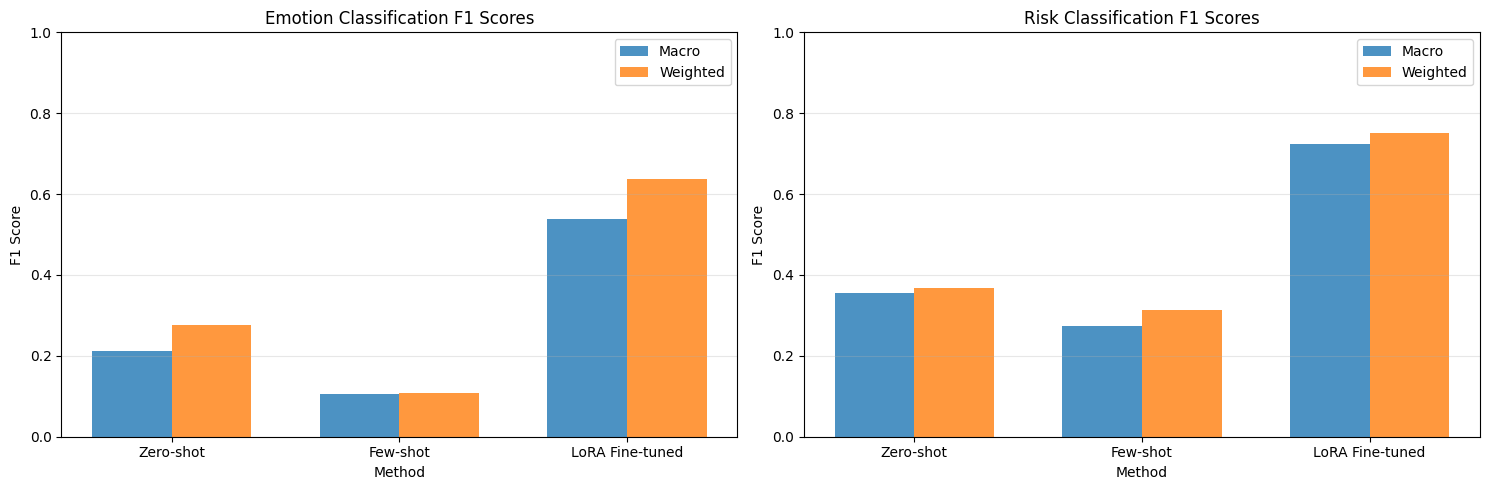

In [21]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Emotion F1 comparison
metrics = ['Emotion F1 (Macro)', 'Emotion F1 (Weighted)']
x = np.arange(len(results_df))
width = 0.35

axes[0].bar(x - width/2, results_df['Emotion F1 (Macro)'], width, label='Macro', alpha=0.8)
axes[0].bar(x + width/2, results_df['Emotion F1 (Weighted)'], width, label='Weighted', alpha=0.8)
axes[0].set_xlabel('Method')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Emotion Classification F1 Scores')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Method'])
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Risk F1 comparison
axes[1].bar(x - width/2, results_df['Risk F1 (Macro)'], width, label='Macro', alpha=0.8)
axes[1].bar(x + width/2, results_df['Risk F1 (Weighted)'], width, label='Weighted', alpha=0.8)
axes[1].set_xlabel('Method')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Risk Classification F1 Scores')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Method'])
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

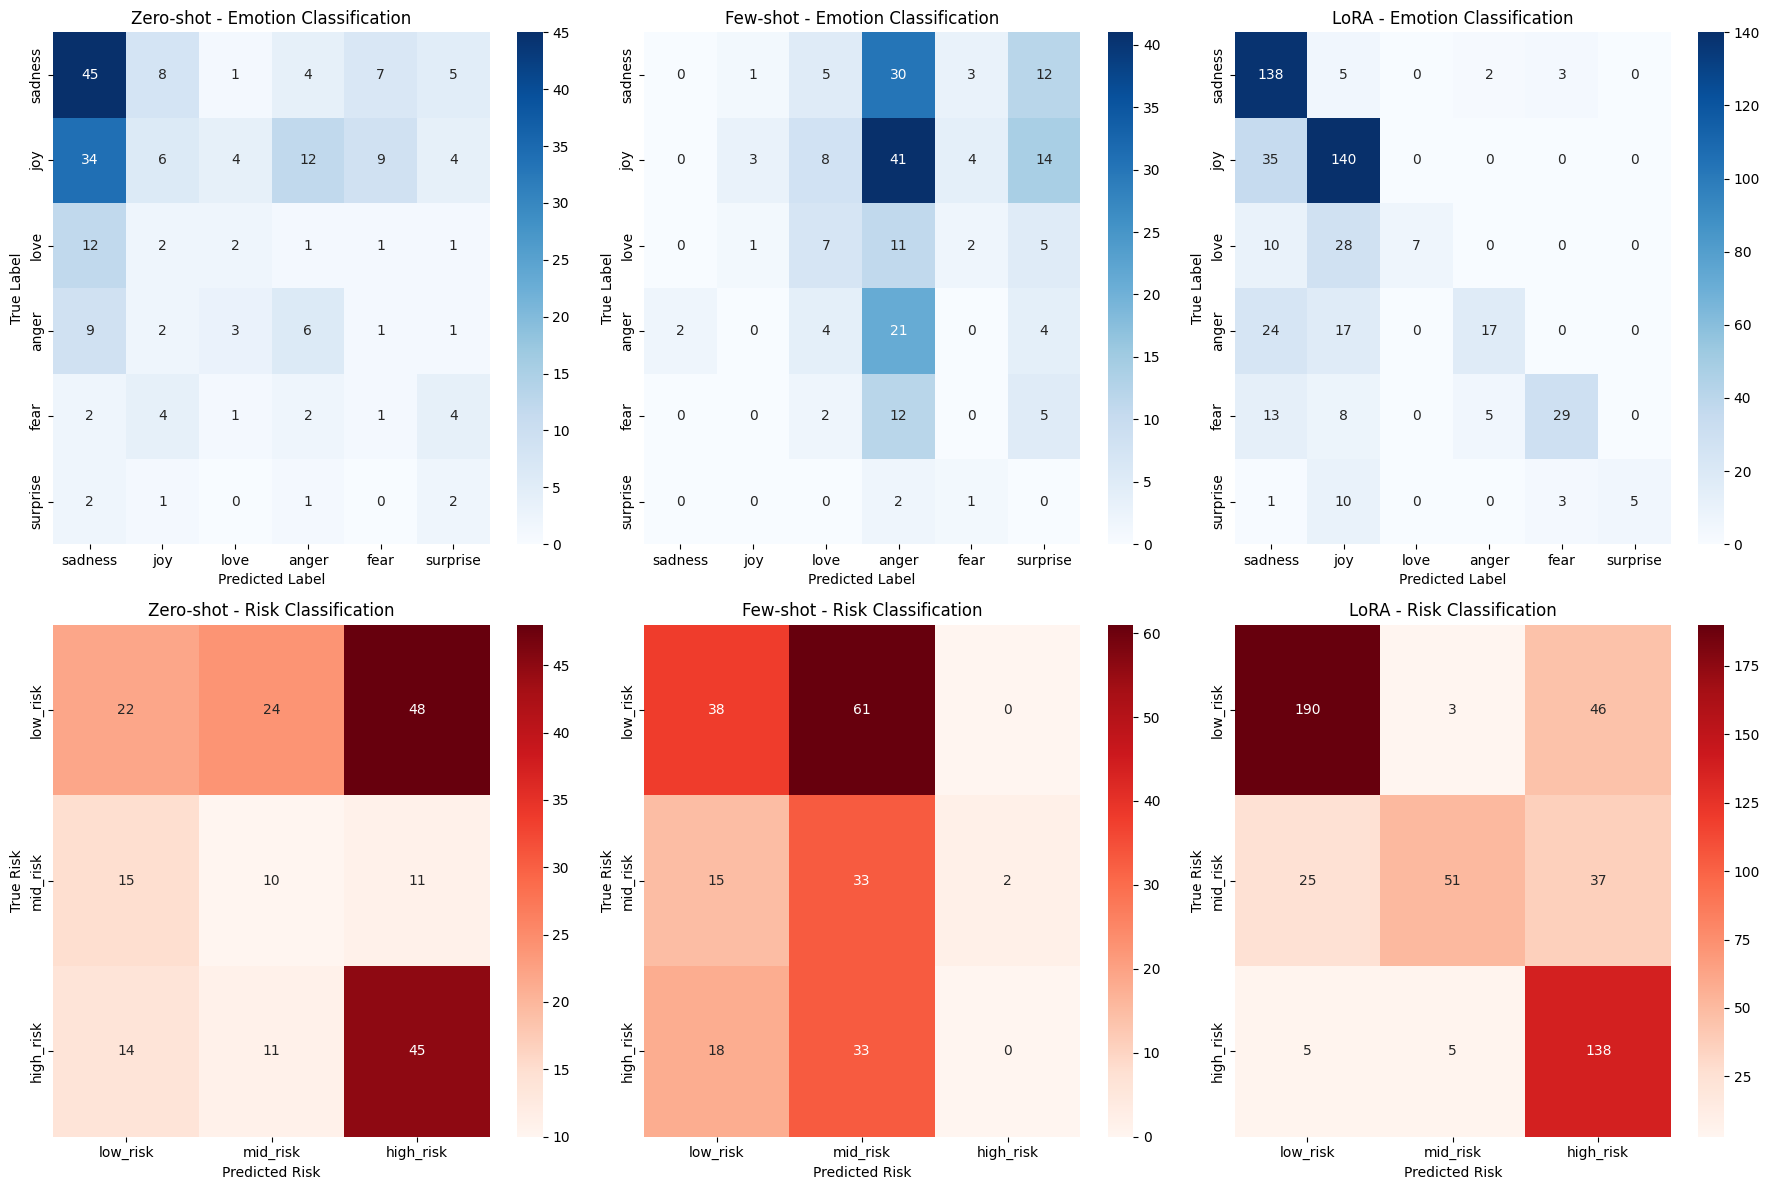

In [22]:
# Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

methods = ['Zero-shot', 'Few-shot', 'LoRA']
preds_list = [zero_shot_preds, few_shot_preds, lora_preds]
true_list = [zero_shot_true, few_shot_true, lora_true]

# Emotion confusion matrices
for i, (method, preds, true) in enumerate(zip(methods, preds_list, true_list)):
    cm = confusion_matrix(true, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_names, yticklabels=emotion_names,
                ax=axes[0, i])
    axes[0, i].set_title(f'{method} - Emotion Classification')
    axes[0, i].set_ylabel('True Label')
    axes[0, i].set_xlabel('Predicted Label')

# Risk confusion matrices
for i, (method, preds, true) in enumerate(zip(methods, preds_list, true_list)):
    true_risk = np.array([emotion_to_risk[label] for label in true])
    pred_risk = np.array([emotion_to_risk[label] for label in preds])
    cm = confusion_matrix(true_risk, pred_risk)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=risk_names, yticklabels=risk_names,
                ax=axes[1, i])
    axes[1, i].set_title(f'{method} - Risk Classification')
    axes[1, i].set_ylabel('True Risk')
    axes[1, i].set_xlabel('Predicted Risk')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. 憂鬱症風險監測視覺化

In [23]:
# Generate risk predictions for entire test set (using best model - LoRA)
print("Generating risk predictions for visualization...")

all_risk_probs = []
all_texts = []

# Use a larger sample for visualization
sample_size = min(1000, len(dataset['test']))
test_indices = np.random.choice(len(dataset['test']), sample_size, replace=False)

for idx in tqdm(test_indices, desc="Computing risk probabilities"):
    sample = dataset['test'][int(idx)]
    all_texts.append(sample['text'])

    # Get emotion prediction
    prompt = create_zero_shot_prompt(sample['text'])
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH).to(device)

    with torch.no_grad():
        outputs = lora_model.generate(
            **inputs,
            max_new_tokens=10,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predicted = response.split("<|assistant|>")[-1].strip().lower()

    # Map to emotion and risk
    pred_emotion = -1
    for i, emotion in enumerate(emotion_names):
        if emotion in predicted:
            pred_emotion = i
            break

    if pred_emotion == -1:
        pred_emotion = sample['label']  # Use true label if prediction fails

    pred_risk = emotion_to_risk[pred_emotion]

    # Create one-hot probability (simplified)
    risk_prob = [0.0, 0.0, 0.0]
    risk_prob[pred_risk] = 1.0
    all_risk_probs.append(risk_prob)

all_risk_probs = np.array(all_risk_probs)
print(f"\nGenerated risk probabilities for {len(all_risk_probs)} samples")

Generating risk predictions for visualization...


Computing risk probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]


Generated risk probabilities for 1000 samples


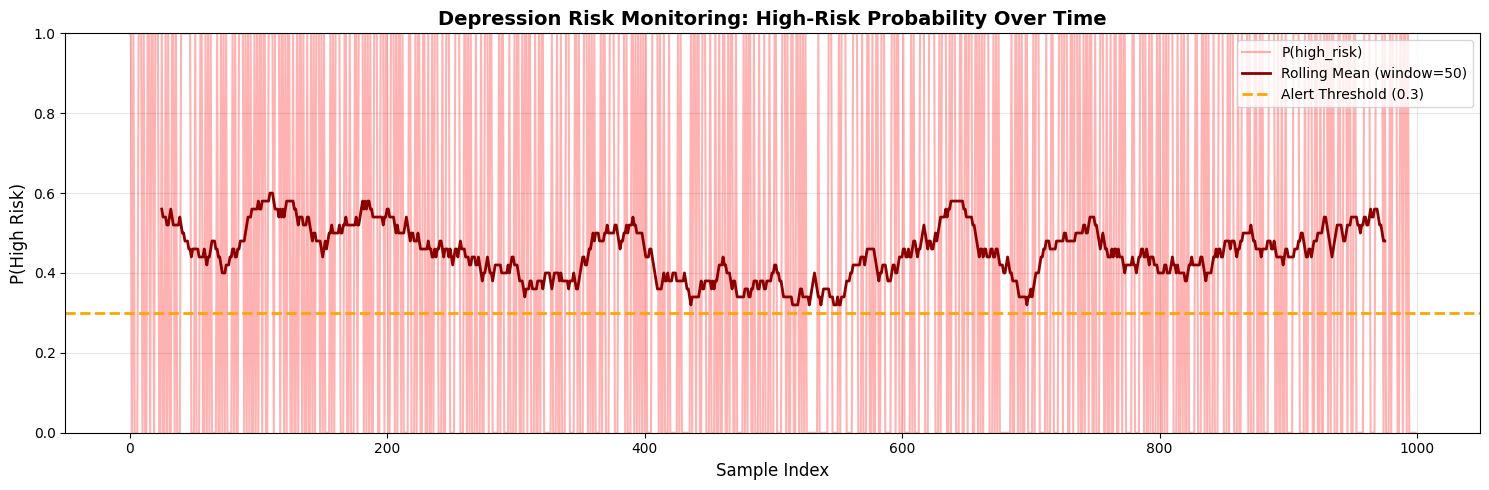


High-Risk Statistics:
  Mean P(high_risk): 0.4540
  Std P(high_risk): 0.4979
  Max P(high_risk): 1.0000
  Samples above threshold: 454 (45.40%)


In [24]:
# Visualization 1: High-risk trend over time
fig, ax = plt.subplots(figsize=(15, 5))

high_risk_probs = all_risk_probs[:, 2]  # P(high_risk)
indices = np.arange(len(high_risk_probs))

# Plot raw probabilities
ax.plot(indices, high_risk_probs, alpha=0.3, color='red', label='P(high_risk)')

# Add rolling mean
window_size = 50
rolling_mean = pd.Series(high_risk_probs).rolling(window=window_size, center=True).mean()
ax.plot(indices, rolling_mean, color='darkred', linewidth=2, label=f'Rolling Mean (window={window_size})')

# Add threshold line
threshold = 0.3
ax.axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Alert Threshold ({threshold})')

ax.set_xlabel('Sample Index', fontsize=12)
ax.set_ylabel('P(High Risk)', fontsize=12)
ax.set_title('Depression Risk Monitoring: High-Risk Probability Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('risk_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics
print(f"\nHigh-Risk Statistics:")
print(f"  Mean P(high_risk): {high_risk_probs.mean():.4f}")
print(f"  Std P(high_risk): {high_risk_probs.std():.4f}")
print(f"  Max P(high_risk): {high_risk_probs.max():.4f}")
print(f"  Samples above threshold: {(high_risk_probs > threshold).sum()} ({(high_risk_probs > threshold).sum() / len(high_risk_probs) * 100:.2f}%)")

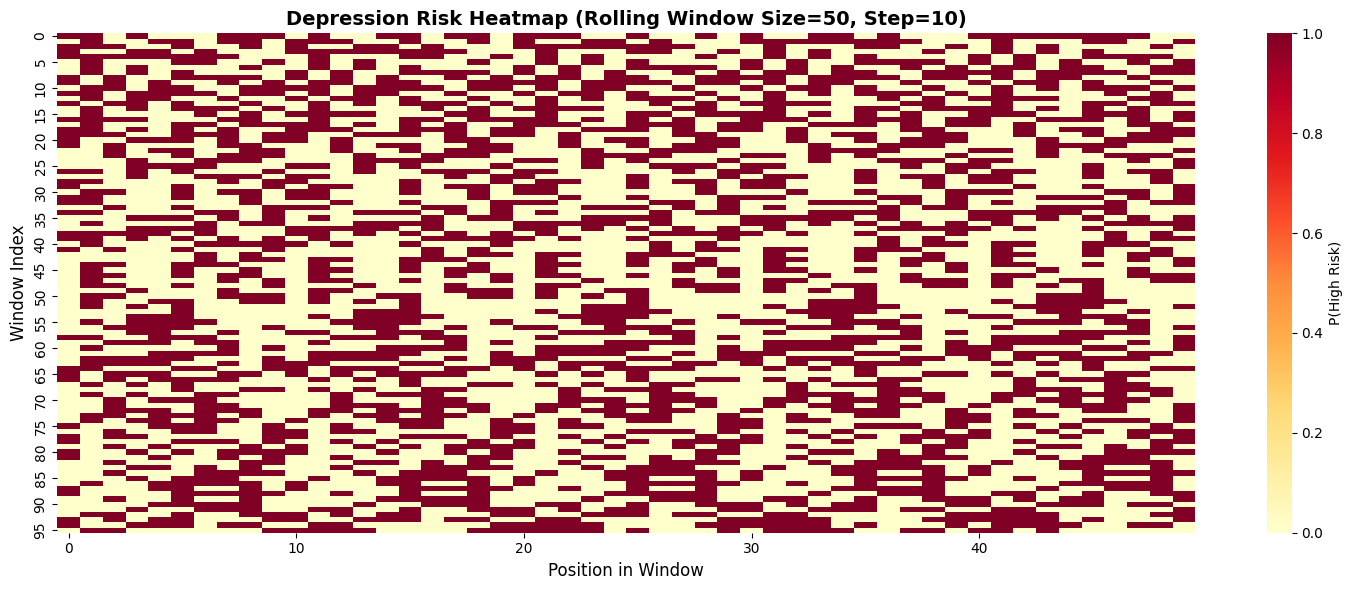


Window Analysis:
  Total windows: 96
  High-risk windows (mean > 0.3): 96
  Highest risk window: 80-130 (mean: 0.5800)


In [25]:
# Visualization 2: High-risk heatmap with rolling window
fig, ax = plt.subplots(figsize=(15, 6))

# Create 2D heatmap with rolling windows
window_size = 50
step_size = 10
n_windows = (len(high_risk_probs) - window_size) // step_size + 1

heatmap_data = []
window_labels = []

for i in range(n_windows):
    start_idx = i * step_size
    end_idx = start_idx + window_size
    window_data = high_risk_probs[start_idx:end_idx]
    heatmap_data.append(window_data)
    window_labels.append(f"{start_idx}-{end_idx}")

heatmap_data = np.array(heatmap_data)

# Plot heatmap
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'P(High Risk)'},
            xticklabels=10, yticklabels=5, ax=ax)
ax.set_xlabel('Position in Window', fontsize=12)
ax.set_ylabel('Window Index', fontsize=12)
ax.set_title(f'Depression Risk Heatmap (Rolling Window Size={window_size}, Step={step_size})',
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('risk_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Window statistics
window_means = heatmap_data.mean(axis=1)
high_risk_windows = np.where(window_means > threshold)[0]
print(f"\nWindow Analysis:")
print(f"  Total windows: {n_windows}")
print(f"  High-risk windows (mean > {threshold}): {len(high_risk_windows)}")
print(f"  Highest risk window: {window_labels[window_means.argmax()]} (mean: {window_means.max():.4f})")

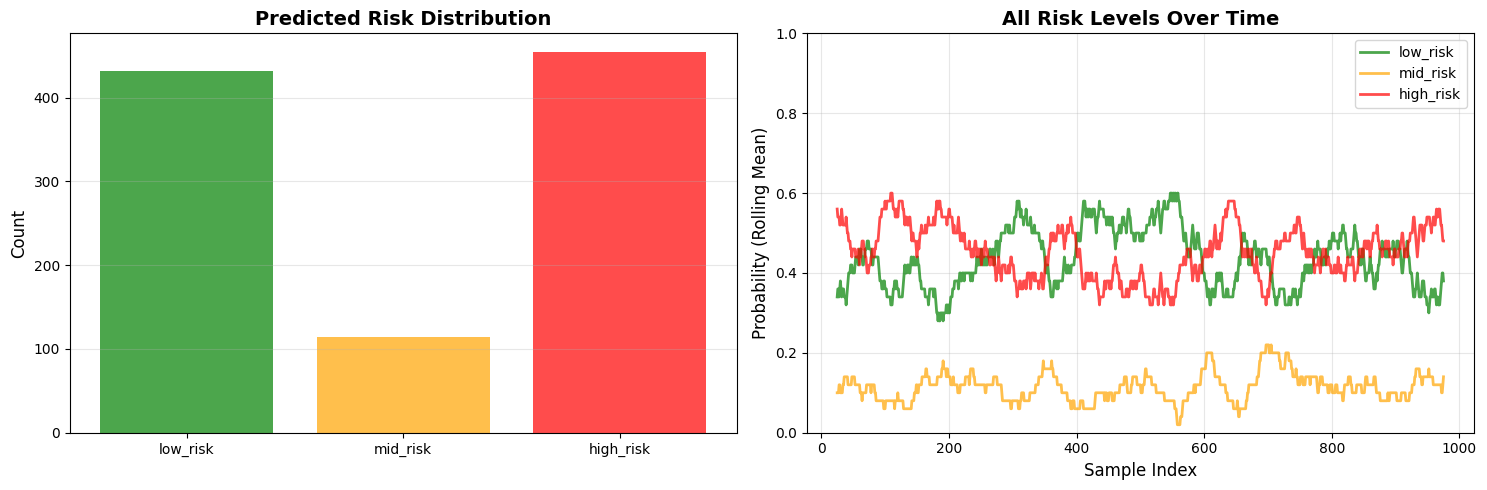

In [26]:
# Additional visualization: Risk distribution over all three levels
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Risk level distribution
risk_counts = pd.Series([np.argmax(prob) for prob in all_risk_probs]).value_counts().sort_index()
colors = ['green', 'orange', 'red']
axes[0].bar([risk_names[i] for i in risk_counts.index],
            risk_counts.values,
            color=[colors[i] for i in risk_counts.index],
            alpha=0.7)
axes[0].set_title('Predicted Risk Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# All risk probabilities over time
for risk_level in range(3):
    probs = all_risk_probs[:, risk_level]
    rolling = pd.Series(probs).rolling(window=50, center=True).mean()
    axes[1].plot(indices, rolling, color=colors[risk_level],
                linewidth=2, label=risk_names[risk_level], alpha=0.7)

axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Probability (Rolling Mean)', fontsize=12)
axes[1].set_title('All Risk Levels Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('risk_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. 結果總結與報告

In [27]:
# Generate summary report
summary_report = f"""
={'='*80}
HW5 - LLM EMOTION CLASSIFICATION & DEPRESSION RISK MONITORING
FINAL SUMMARY REPORT
={'='*80}

1. DATASET INFORMATION
   - Source: HuggingFace emotion dataset (dair-ai/emotion)
   - Training samples: {len(dataset['train'])}
   - Validation samples: {len(dataset['validation'])}
   - Test samples: {len(dataset['test'])}
   - Emotion classes: {', '.join(emotion_names)}
   - Risk classes: {', '.join(risk_names)}

2. MODEL CONFIGURATION
   - Base model: {MODEL_NAME}
   - Max sequence length: {MAX_LENGTH}
   - Quantization: 4-bit (NF4)
   - LoRA rank (r): 16
   - LoRA alpha: 32
   - LoRA dropout: 0.05

3. TRAINING PARAMETERS
   - Epochs: {training_args.num_train_epochs}
   - Batch size: {training_args.per_device_train_batch_size}
   - Learning rate: {training_args.learning_rate}
   - Optimizer: paged_adamw_8bit
   - Scheduler: cosine with warmup

4. PERFORMANCE COMPARISON
"""

print(summary_report)
print(results_df.to_string(index=False))

print(f"""

5. KEY FINDINGS
   - Best performing method: {results_df.loc[results_df['Emotion F1 (Weighted)'].idxmax(), 'Method']}
   - Emotion F1 improvement (LoRA vs Zero-shot): {(results_df.loc[2, 'Emotion F1 (Weighted)'] - results_df.loc[0, 'Emotion F1 (Weighted)']) * 100:.2f}%
   - Risk F1 improvement (LoRA vs Zero-shot): {(results_df.loc[2, 'Risk F1 (Weighted)'] - results_df.loc[0, 'Risk F1 (Weighted)']) * 100:.2f}%

6. RISK MONITORING INSIGHTS
   - Mean P(high_risk): {high_risk_probs.mean():.4f}
   - Samples flagged as high-risk: {(high_risk_probs > threshold).sum()} / {len(high_risk_probs)} ({(high_risk_probs > threshold).sum() / len(high_risk_probs) * 100:.2f}%)
   - Alert threshold: {threshold}

7. MODEL LIMITATIONS & CONSIDERATIONS
   - Limited to text-based emotion detection (no multimodal signals)
   - Risk mapping is simplified (rule-based, not clinically validated)
   - Model may have biases from training data
   - Should not be used as sole diagnostic tool for mental health
   - Requires validation with domain experts and clinical data
   - Privacy and ethical considerations for real-world deployment

8. FILES GENERATED
   - lora_emotion_final/ (trained model)
   - method_comparison.png
   - confusion_matrices.png
   - risk_trend.png
   - risk_heatmap.png
   - risk_comprehensive.png

={'='*80}
""")

# Save report to file
with open('HW5_Summary_Report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)
    f.write(results_df.to_string(index=False))

print("\nSummary report saved to: HW5_Summary_Report.txt")


HW5 - LLM EMOTION CLASSIFICATION & DEPRESSION RISK MONITORING
FINAL SUMMARY REPORT

1. DATASET INFORMATION
   - Source: HuggingFace emotion dataset (dair-ai/emotion)
   - Training samples: 16000
   - Validation samples: 2000
   - Test samples: 2000
   - Emotion classes: sadness, joy, love, anger, fear, surprise
   - Risk classes: low_risk, mid_risk, high_risk

2. MODEL CONFIGURATION
   - Base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
   - Max sequence length: 128
   - Quantization: 4-bit (NF4)
   - LoRA rank (r): 16
   - LoRA alpha: 32
   - LoRA dropout: 0.05

3. TRAINING PARAMETERS
   - Epochs: 3
   - Batch size: 4
   - Learning rate: 0.0002
   - Optimizer: paged_adamw_8bit
   - Scheduler: cosine with warmup

4. PERFORMANCE COMPARISON

         Method  Emotion F1 (Macro)  Emotion F1 (Weighted)  Risk F1 (Macro)  Risk F1 (Weighted)    AUROC   PR-AUC
      Zero-shot            0.210921               0.275661         0.355868            0.368100 0.529577 0.392268
       Few-shot         